# Introduction and Setup

Arnie is back, and this time, he's on our side. We need to update out training set to make sure we can build models that can correctly identify our new cyborg ally as a friend. 

This notebook makes use of a TCAV model to identify Arnie by making use of a Concept Activation Vector (CAV) representing the Arnie "concept" within the same activation space as the various hidden layers of our model. By finding examples that are sensitive to the Arnie concept within the "opponents of humanity" class in our training set, we are also finding those examples which need to be converted to the "supporters of humanity" class in order to produce a new training set which improves model performance on the test set.

Each required deliverable is noted upon its completion by the reference "D\<deliverable number\>". To dive deeper into the solution, you are invited to review the accompanying python scripts. 

In [1]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd drive/MyDrive/tenyks/

Mounted at /content/drive
/content/drive/MyDrive/tenyks


In [1]:
# Imports
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from TCAV import TCAV
from FeatureExtractor import FeatureExtractor
from Trainer import Trainer
from ModelExplainer import ModelExplainer
from utils import *

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data

For this project, I made extensive use of PyTorch DataLoaders, and ImageFolders. To make use of these ImageFolders, the project root directory must have the following file tree:



```
├── ./arnie
│   ├── ./arnie/0
│   └── ./arnie/1
├── ./test
│   ├── ./test/0
│   └── ./test/1
├── ./train
│   ├── ./train/0
│   └── ./train/1
```

For each ImageFoler, there is a subdirectory of positive and negative examples. This is the same structure as the ```train``` and ```test``` data folders provided. In the case of the ```arnie``` concept folder, the postive examples are images of Arnie, and the negative examples are a random selection of unrelated images, as is required when generating CAVs.





In [3]:
# Data processing definition
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load Datasets
train_dataset = ImageFolder(root = 'train', transform = transform)
test_dataset = ImageFolder(root = 'test', transform = transform)

In [4]:
# Generate DataLoaders
batch_size = 16
train_loader, valid_loader = get_train_loaders(train_dataset, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

# Load Model

Throught this assignment, I made use of a custom model wrapper for PyTorch's implementation of AlexNet. I went with AlexNet for its relatively small size and fast training compared to many more modern architectures. I made the assumption that due to the relative simplicity of the classification problem, AlexNet would have sufficient performance, despite it being outperformed by other models on more complex problems.

The wrapper, found in ```ModelExplainer.py```, adds functionality which is able to return the gradients and activations of a set of the model's layers for a given input. This is useful when visualizing the models activation space, and for calculating the TCAV score of the model for a given class and concept.

By default, a pretrained (on ImageNet-1K) version of AlexNet is loaded, in order to improve model performance by making use of transfer learning.

In [4]:
# The convolutional layers of the model which are to be tracked (in terms of their gradients and activations)
layers = [4,9,12]

# Create an instance of the model
model_explainer = ModelExplainer(layers, num_classes=2,load_path='models/model_2.pth')

Note that the layer indices included in the ```layers``` list correspond to the following model layers:

In [49]:
model_explainer.model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# D1: Train initial CNN model

To train the model, I made use of a custom ```Trainer``` class, which has functionality to train and validate the model.

[INFO]: Epoch 1 of 3
Training
Validation
Training loss: 0.060, training acc: 98.008
Validation loss: 0.028, validation acc: 99.083
--------------------------------------------------
[INFO]: Epoch 2 of 3
Training
Validation
Training loss: 0.002, training acc: 99.847
Validation loss: 0.000, validation acc: 100.000
--------------------------------------------------
[INFO]: Epoch 3 of 3
Training
Validation
Training loss: 0.000, training acc: 100.000
Validation loss: 0.000, validation acc: 100.000
--------------------------------------------------
TRAINING COMPLETE


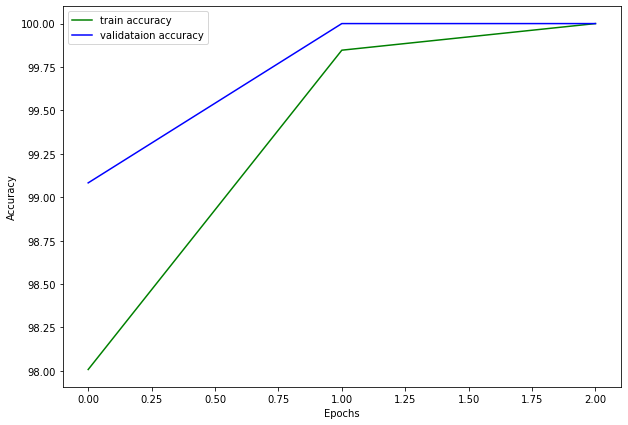

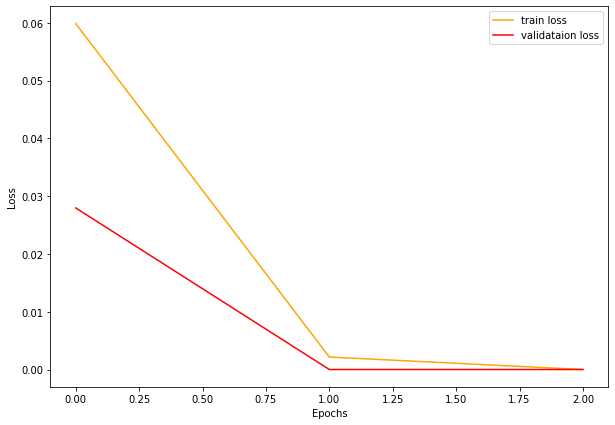

In [ ]:
# Create Trainer 
trainer = Trainer()

# Train and validate the model
trainer.fit(model_explainer.model, train_loader, valid_loader, epochs = 3, show = True)

It looks like the transfer learning approach really paid off, as we were able to train the model to 100% training and validation accuracy in only 3 epochs. 

Now we must evaluate the model's performance on the test set:

In [69]:
loss, accuracy = trainer.validate(model_explainer.model, test_loader,nn.CrossEntropyLoss())
print(f'Test set accuracy: {accuracy}')

Validation
Test set accuracy: 87.5


As expected, performance suffers on the test set due to the Arnie being labeled as evil in the training set. We better fix that!

# D3,4: TCAV implementation and training

I created a TCAV class, which when instantiated creates and internally saves a set of CAV vectors for each concept and model layer pair, so that the TCAV score of an image can be calculated for each tracked layer of the model.

In [6]:
# Get Arnie concept dataset. I make use of a util function which expands the dataset using image augmentation techniques.
import importlib
import utils
importlib.reload(utils)
from utils import *
concept_dataset = expand_dataset('arnie_small')

In [ ]:
from torchvision.utils import save_image

for i,(data,target) in enumerate(concept_dataset):
    save_image(data,f'augment/{target}/aug_{i}.jpg')

In [ ]:
# Generate TCAV model
concepts = [concept_dataset]
tcav = TCAV(model_explainer, concepts)

# D2,5: Hidden space visualization

In order to easily access the hidden space activations across the models layers for a given dataset, a custom ```FeatureExtractor``` class was created. This class can also be used to generate activation gradients across layers, which is essential for calculating TCAV scores for a given data class.

To visualize the class activation spaces and CAV vector for a given layer of the model, t-SNE data reduction was applied.

In [9]:
# Create Feature Extractor
feature_extractor = FeatureExtractor(model_explainer)

# Generate model hidden activations
activations = feature_extractor.get_activations(train_dataset)

In [134]:
stand_acts = activations.copy()
for c in ['0','1']:
    for l in layers:
        l=str(l)
        stand_acts[c][l] = (stand_acts[c][l]-stand_acts[c][l].mean())/stand_acts[c][l].std()

In [10]:
vector=tcav.cavs['arnie_small']['4']
activations[c][l]
stand_acts[c][l]==activations[c][l]

NameError: name 'tcav' is not defined

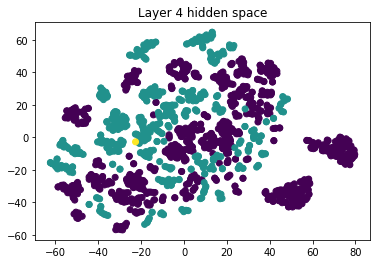

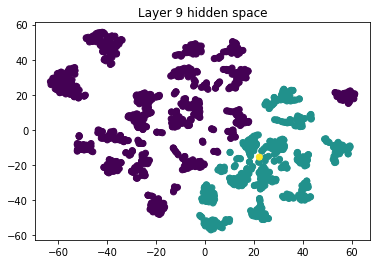

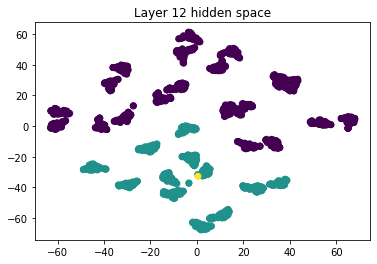

In [135]:
import warnings
warnings.filterwarnings('ignore')
import utils
importlib.reload(utils)
from utils import *

# Visualize the hidden activation space for each model layer being tracked
for layer_number in layers:
  visualize_activation_space(stand_acts,layer_number,cav = tcav.cavs['arnie_small'])
  plt.title(f'Layer {layer_number} hidden space')
  plt.show()

Note the following Legend for the above figures:


*   Turquoise: Allies of humanity
*   Dark purple: Opponents of humanity
*   Yellow: Arnie concept vector


These are some fascinating results! These visualizations show us that as we go deeper into the model, there is better separability between the classes. This is of course because the activations in these later layers represent high-level features of the input images, and are therefore more useful for the final classification, and to separate the classes in the models hidden space.

These visualizations also show us that the models activations appear in distinct dense clusters. This is due to the extensive ammount of image augmentaiton found in the training dataset (being visualized here), as the model has similar activations for a set of augmented images derrived from the same original image.

# D6,7: Arnie is back!

We are about to make the famous catchphrase a reality. Arnie is coming back to the "ally of humanity" class! We can identify Arnie in the evil dataset by finding images in that set which have a high conceptual sensitivity to the Arnie CAV. Once we have identified these images, we can change their labels to bring Arnie onto the side of humanity!

While we do this, we are also going to take a look at each classes conceptual sensitivity to the Arnie concept.

In [11]:
# Get gradients
gradients = feature_extractor.get_gradients(train_dataset)

In [25]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
    ])
cd=ImageFolder(root='augment',transform=transform)
cd = torch.utils.data.ConcatDataset(
        [cd])


In [12]:
# Get Arnie concept dataset. I make use of a util function which expands the dataset using image augmentation techniques.
import importlib
import utils
importlib.reload(utils)
from utils import *
concept_dataset = expand_dataset('arnie_small')

In [1]:
# Generate TCAV model
import importlib
import TCAV
importlib.reload(TCAV)
from TCAV import TCAV
model_explainer.model.eval()
concepts = [concept_dataset]
#concepts=[cd]
tcav = TCAV(model_explainer, concepts)

# Calculate and print TCAV scores for the highest level layer
print(f"Allies TCAV score: {round(tcav.get_score(gradients, concept = 'arnie_small', data_class = '1', layer = '12'),2)}")
print(f"Opponents TCAV score: {round(tcav.get_score(gradients, concept = 'arnie_small', data_class = '0', layer = '12'),2)}")

NameError: name 'model_explainer' is not defined

It appears that around 21% of the evil class are sensitive to the Arnie concept. Lets take a look at a few of these examples:

In [131]:
# Get indexes which are sensitive to Arnie concept
sensitive_indexes_opposition = tcav.get_sensitive_indexes(gradients, 'arnie_small', '0', '12')

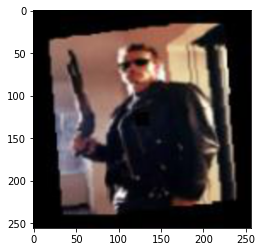

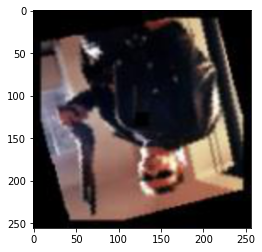

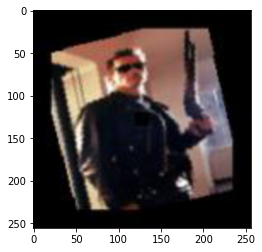

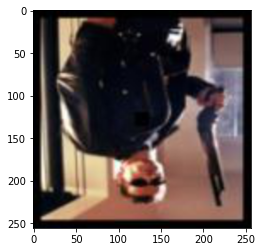

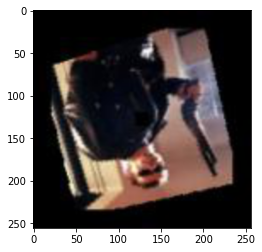

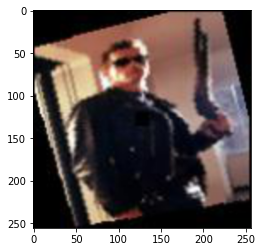

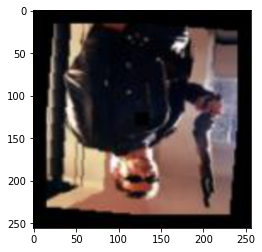

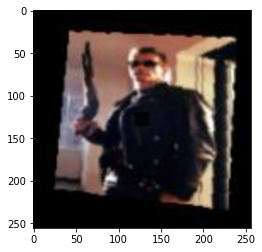

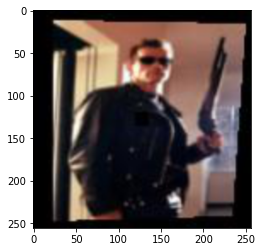

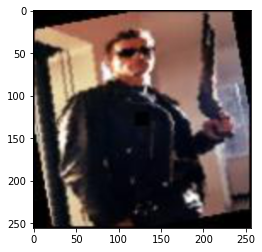

In [132]:
# Print samples
for i in sensitive_indexes_opposition[0:10]:
  d, t = train_dataset[i]
  plt.imshow(d.squeeze().permute(1, 2, 0))
  plt.show()

This sample of images shows that the examples which are sensitive to Arnie in the opposition class represent those images which contain the Governator himself. This is a small sample, but I took a deep dive into these indexes, and every example was an image of Arnie.

# D7,8: Changing labels and retraining

Now that we can identify Arnie in the evil dataset, we can change the labels of those images, and retrain the model on the new dataset.

In [46]:
# Load corrected data
train_dataset_new = change_sensitive_labels(train_dataset, sensitive_indexes_opposition)
train_loader, valid_loader = get_train_loaders(train_dataset_new)

In [ ]:
# Create new model for training
model_explainer_new = ModelExplainer(layers, 2)

In [52]:
# Train model using new data
trainer.fit(model_explainer_new.model, train_loader, valid_loader, epochs=3)

[INFO]: Epoch 1 of 3
Training
Validation
Training loss: 0.034, training acc: 98.161
Validation loss: 0.000, validation acc: 100.000
--------------------------------------------------
[INFO]: Epoch 2 of 3
Training
Validation
Training loss: 0.000, training acc: 100.000
Validation loss: 0.000, validation acc: 100.000
--------------------------------------------------
[INFO]: Epoch 3 of 3
Training
Validation
Training loss: 0.000, training acc: 100.000
Validation loss: 0.000, validation acc: 100.000
--------------------------------------------------
TRAINING COMPLETE


In [54]:
# Validate on test set
loss,accuracy=trainer.validate(model_explainer_new.model, test_loader, nn.CrossEntropyLoss())
print(f'Test set accuracy: {accuracy}')

Validation
Test set accuracy: 100.0


Success! Our corrections to the training set succesfully improved the performance of the model on the test set. We now have the T-1000 on our side, and are ready to take on SkyNet!